<a href="https://colab.research.google.com/github/liao961120/cilin/blob/main/etc/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Install dependencies
!pip install -q CompoTree
!pip install -q cilin
!pip install -q opencc

# Download font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -qo NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

# Download data
!wget -q https://github.com/liao961120/cilin/archive/refs/heads/main.zip
!unzip -q main.zip
!mv cilin-main/etc/* .

     |████████████████████████████████| 1.3 MB 9.1 MB/s 
     |████████████████████████████████| 600 kB 8.6 MB/s 
     |████████████████████████████████| 766 kB 8.0 MB/s 
--2021-12-09 01:46:47--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M   223MB/s    in 0.5s    

2021-12-09 01:46:48 (223 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

replace cilin-main/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: mv: cannot stat 'cilin-main/etc/*': No such file or directory


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager  

# Set chinese font for plotting
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
  font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [7]:
import json
import numpy as np
import pandas as pd
from cilin import Cilin
from CompoTree import Radicals
from collections import Counter
from itertools import product, chain
from random import sample
from utils import *

C = Cilin(trad=True)
all_words = chain.from_iterable(C.category_split().values())
# Tagger = RadicalSemanticTagger(all_words=all_words, bigram=False)  # Use unigram feature only
Tagger = RadicalSemanticTagger(all_words=all_words, bigram=True)
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)
df_feat, df_tgt = DTM.pd, DTM.df_tgt

## 同義詞詞林

<img src="https://github.com/liao961120/cilin/raw/main/etc/cilin_encoding.png" width=59% style="display:inlin-block">

<img src="https://github.com/liao961120/cilin/raw/main/etc/cilin_hierarchy.png" width=40% style="display:inlin-block">


In [102]:
for t in "D Da Da15 Da15B Da15C".split():
    print(t, "\t Class label   :  ", C.get_tag(t))
    print("\t Example members: ", list(C.get_members(t))[:10])
    print("\t Semantic tags  : ", Tagger.bow(C.get_members(t)).most_common(5))
    print()

D 	 Class label   :   抽象事物
	 Example members:  ['語序', '農學會', '背日性', '醫學', '極', '短見', '楷範', '幹勁', '兩河鎮', '盲字']
	 Semantic tags  :  [('無生命', 6533), ('NULL', 4795), ('植物', 3144), ('人體四肢', 3014), ('穿著器物', 2444)]

Da 	 Class label   :   事情 情況
	 Example members:  ['困苦', '光合作用', '業績', '革命史', '過失', '望', '訟案', '憾', '藝途', '行政']
	 Semantic tags  :  [('無生命', 408), ('NULL', 267), ('生命性質', 200), ('人體四肢', 197), ('植物', 163)]

Da15 	 Class label   :   是非 差錯 漏洞
	 Example members:  ['病', '謬', '漏洞', '不對', '失之偏頗', '誰是誰非', '漏子', '紕繆', '錯處', '尾巴']
	 Semantic tags  :  [('NULL', 20), ('無生命', 16), ('野獸', 7), ('生命性質', 6), ('人體四肢', 6)]

Da15B 	 Class label   :   差錯 過錯 錯誤 錯處 偏差 偏向 不是 謬誤 舛誤 訛誤 不對 訛謬 紕繆 錯 差 病 誤 訛 謬 魯魚亥豕 魯魚帝虎 大過 錯事 一差二錯 誤差 誤區 語病 故障 跑題 失之偏頗 錯失良機 明珠暗投
	 Example members:  ['病', '謬', '不對', '失之偏頗', '紕繆', '錯處', '陰差陽錯', '不是', '魯魚亥豕', '大過']
	 Semantic tags  :  [('NULL', 10), ('無生命', 9), ('人體四肢', 6), ('NULL_NULL', 6), ('野獸', 5)]

Da15C 	 Class label   :   漏洞 漏子 破綻 紕漏 罅漏 馬腳 尾巴 狐狸尾巴
	 Example members:  ['漏洞', '

## Document Term Matrix

- Document: 詞林 Level 3 類別   
  e.g. `Aa01` (`A:人`, `Aa:人-泛稱`, `Aa01:人 人民 衆人 角色`)
- Feature: 1-gram Semantic label + 2-gram Semantic label


In [8]:
print("Documents:")
print("  ", DTM.documents[:10])
print('\n   Example (Aa01):\n      ', Tagger.bow(C.get_members('Aa01')))

print("\n\nFeatures:")
print("  ", DTM.features[:5] + DTM.features[-5:])

Documents:
   ['Aa01', 'Aa02', 'Aa03', 'Aa04', 'Aa05', 'Aa06', 'Ab01', 'Ab02', 'Ab03', 'Ab04']

   Example (Aa01):
       Counter({'人': 23, '人倫關係': 18, '無生命': 16, '生命性質': 15, 'NULL': 12, '人體四肢': 9, '植物': 7, '人_人': 6, '顏色': 6, '人體頭部': 6, '性質': 5, '住宿': 5, '城鄉': 4, '人_人體頭部': 4, '生活器物': 4, '無生命_人倫關係': 3, '武器': 3, '人_人體四肢': 3, '人體精神': 3, '人_生命性質': 3, '人_無生命': 3, '禮樂': 3, '人_人倫關係': 3, '植物_人倫關係': 3, '穿著器物': 2, '人體四肢_人倫關係': 2, '生命性質_住宿': 2, 'NULL_人體內部': 2, '生命性質_人倫關係': 2, '顏色_人倫關係': 2, '生活器物_人倫關係': 2, '人體頭部_人倫關係': 2, '野獸': 2, '人倫關係_人': 2, 'NULL_人': 2, 'NULL_生命性質': 2, '人_家畜': 2, '家畜_人體內部': 2, '武器_人倫關係': 2, '家畜': 2, '人倫關係_人體四肢': 1, '穿著器物_植物': 1, '穿著器物_性質': 1, '無生命_野獸': 1, '人體四肢_人體四肢': 1, '野獸_植物': 1, '無生命_家畜': 1, '禮樂_家畜': 1, '植物_生命性質': 1, '植物_家畜': 1, '植物_人': 1, '性質_人': 1, '生命性質_人': 1, '人體頭部_人': 1, '住宿_人倫關係': 1, '動物軀體_顏色': 1, '穿著器物_穿著器物': 1, '城鄉_人倫關係': 1, '生活器物_顏色': 1, '顏色_NULL': 1, '性質_人體四肢': 1, '人倫關係_人體內部': 1, '人體四肢_人': 1, '穿著器物_NULL': 1, '人體內部_住宿': 1, '生命性質_人體內部': 1, '顏色_人體頭部': 1, '人倫關係_人倫關係':

In [9]:
pd.DataFrame(DTM.np, index=DTM.documents, columns=DTM.features)

,NULL,人,人倫關係,人體內部,人體四肢,人體性質,人體精神,人體頭部,住宿,動物軀體,城鄉,家畜,廚房器物,性質,植物,武器,無生命,生命性質,生活器物,禮樂,穿著器物,野獸,顏色,NULL_NULL,NULL_人,NULL_人倫關係,NULL_人體內部,NULL_人體四肢,NULL_人體性質,NULL_人體精神,NULL_人體頭部,NULL_住宿,NULL_動物軀體,NULL_城鄉,NULL_家畜,NULL_廚房器物,NULL_性質,NULL_植物,NULL_武器,NULL_無生命,...,野獸_人體性質,野獸_人體精神,野獸_人體頭部,野獸_住宿,野獸_動物軀體,野獸_城鄉,野獸_家畜,野獸_廚房器物,野獸_性質,野獸_植物,野獸_武器,野獸_無生命,野獸_生命性質,野獸_生活器物,野獸_禮樂,野獸_穿著器物,野獸_野獸,野獸_顏色,顏色_NULL,顏色_人,顏色_人倫關係,顏色_人體內部,顏色_人體四肢,顏色_人體性質,顏色_人體精神,顏色_人體頭部,顏色_住宿,顏色_城鄉,顏色_家畜,顏色_廚房器物,顏色_性質,顏色_植物,顏色_武器,顏色_無生命,顏色_生命性質,顏色_生活器物,顏色_禮樂,顏色_穿著器物,顏色_野獸,顏色_顏色
Aa01,0.174809,0.382876,0.366798,0.036422,0.131761,0.0,0.069208,0.099295,0.093680,0.0,0.081643,0.047363,0.000000,0.104684,0.112182,0.061583,0.223076,0.240741,0.092774,0.078742,0.038721,0.043933,0.155902,0.000000,0.070195,0.042605,0.131305,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048384,0.0,0.0,0.0,0.060868,0.0,0.0,0.0,0.0,0.056161,0.0,0.131305,0.0,0.0,0.0,0.0,0.058114,0.0,0.0,0.071323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aa02,0.074476,0.127659,0.156270,0.000000,0.000000,0.0,0.058971,0.126911,0.000000,0.0,0.052175,0.000000,0.000000,0.053519,0.000000,0.052473,0.071279,0.082052,0.000000,0.000000,0.000000,0.000000,0.000000,0.071787,0.000000,0.000000,0.000000,0.149539,0.173244,0.0,0.084935,0.093890,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aa03,0.138328,0.052691,0.064500,0.000000,0.000000,0.0,0.219058,0.104764,0.000000,0.0,0.000000,0.074958,0.000000,0.000000,0.050726,0.000000,0.264782,0.253999,0.000000,0.000000,0.000000,0.000000,0.000000,0.088889,0.222183,0.000000,0.000000,0.092583,0.000000,0.0,0.105169,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aa04,0.197194,0.225341,0.137922,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aa05,0.345794,0.564503,0.000000,0.000000,0.000000,0.0,0.000000,0.056119,0.000000,0.0,0.138429,0.000000,0.000000,0.000000,0.108691,0.139221,0.000000,0.054424,0.000000,0.000000,0.000000,0.000000,0.000000,0.190463,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.124553,0.0,0.0,0.0,0.0,0.0,0.0,0.137301,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
La02,0.045808,0.000000,0.000000,0.000000,0.046036,0.0,0.000000,0.052040,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043842,0.050468,0.000000,0.082536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.208964,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.31759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
La03,0.000000,0.000000,0.172848,0.000000,0.124181,0.0,0.000000,

## (Multinomial) Naive Bayes Classifier

In [28]:
from sklearn.naive_bayes import MultinomialNB

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['J 關聯']


,precision,recall,f1-score,support
A 人,0.857143,0.500000,0.631579,36.000000
B 物,0.583333,0.777778,0.666667,72.000000
C 時空,1.000000,0.055556,0.105263,18.000000
D 抽象事物,0.239130,0.211538,0.224490,52.000000
E 特徵,0.343284,0.425926,0.380165,54.000000
F 動作,0.000000,0.000000,0.000000,17.000000
G 心理活動,0.500000,0.461538,0.480000,13.000000
H 活動,0.367470,0.685393,0.478431,89.000000
I 現象與狀態,0.000000,0.000000,0.000000,39.000000
J 關聯,0.000000,0.000000,0.000000,13.000000


## Permutation Importance: Selecting Important Features

In [11]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, r2_score

# df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score),
    'f1': 'f1_weighted',
}
imps = permutation_importance(model, X_test, y_test, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=2, n_jobs=-1, random_state=100)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
importances = imps['f1']['importances_mean']
# std = imps['f1']['importances_std']

# model.score(X_test, y_test)
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])
df_importance

,accuracy,f1,precision,recall
NULL,0.008178,0.008935,0.015146,0.008178
人,0.000000,0.001190,0.000365,0.000000
人倫關係,0.004673,0.003707,0.000973,0.004673
人體內部,0.000000,-0.000049,0.000167,0.000000
人體四肢,0.004673,0.003202,0.003739,0.004673
...,...,...,...,...
顏色_生活器物,0.000000,0.000003,-0.000358,0.000000
顏色_禮樂,-0.002336,-0.001770,-0.001355,-0.002336
顏色_穿著器物,0.000000,0.000000,0.000000,0.000000
顏色_野獸,0.002336,0.001897,0.001679,0.002336


In [13]:
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')
df_importance_selected

,accuracy,f1,precision,recall
NULL,0.008178,0.008935,0.015146,0.008178
人倫關係,0.004673,0.003707,0.000973,0.004673
人體四肢,0.004673,0.003202,0.003739,0.004673
人體性質,0.001168,0.001967,0.002766,0.001168
人體精神,0.001168,0.003317,0.003354,0.001168
...,...,...,...,...
野獸_野獸,0.002336,0.001625,0.001244,0.002336
野獸_顏色,0.002336,0.002787,0.002779,0.002336
顏色_植物,0.001168,0.000698,0.000635,0.001168
顏色_生命性質,0.001168,0.000854,0.000951,0.001168


## Feature importance of each class

In [16]:
from copy import deepcopy

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [17]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

scoreDiff = {}
rmFeat = []
for col in df_importance_selected.index:
    # X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    # Shuffle
    X_train_drop, X_test_drop = X_train.copy(deep=True), X_test.copy(deep=True)
    X_train_drop[col] = X_train_drop[col].sample(frac=1, random_state=100).values
    X_test_drop[col] = X_test_drop[col].sample(frac=1, random_state=100).values
    # df1['HS_FIRST_NAME'] = df[4].sample(frac=1).values

    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(baseScore['accuracy']- val)
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                k = f"{cls}_{stat}"
                if any(x in k for x in 'support macro weighted'.split()): continue
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(base_val - val)

df = pd.DataFrame(scoreDiff, index=rmFeat)

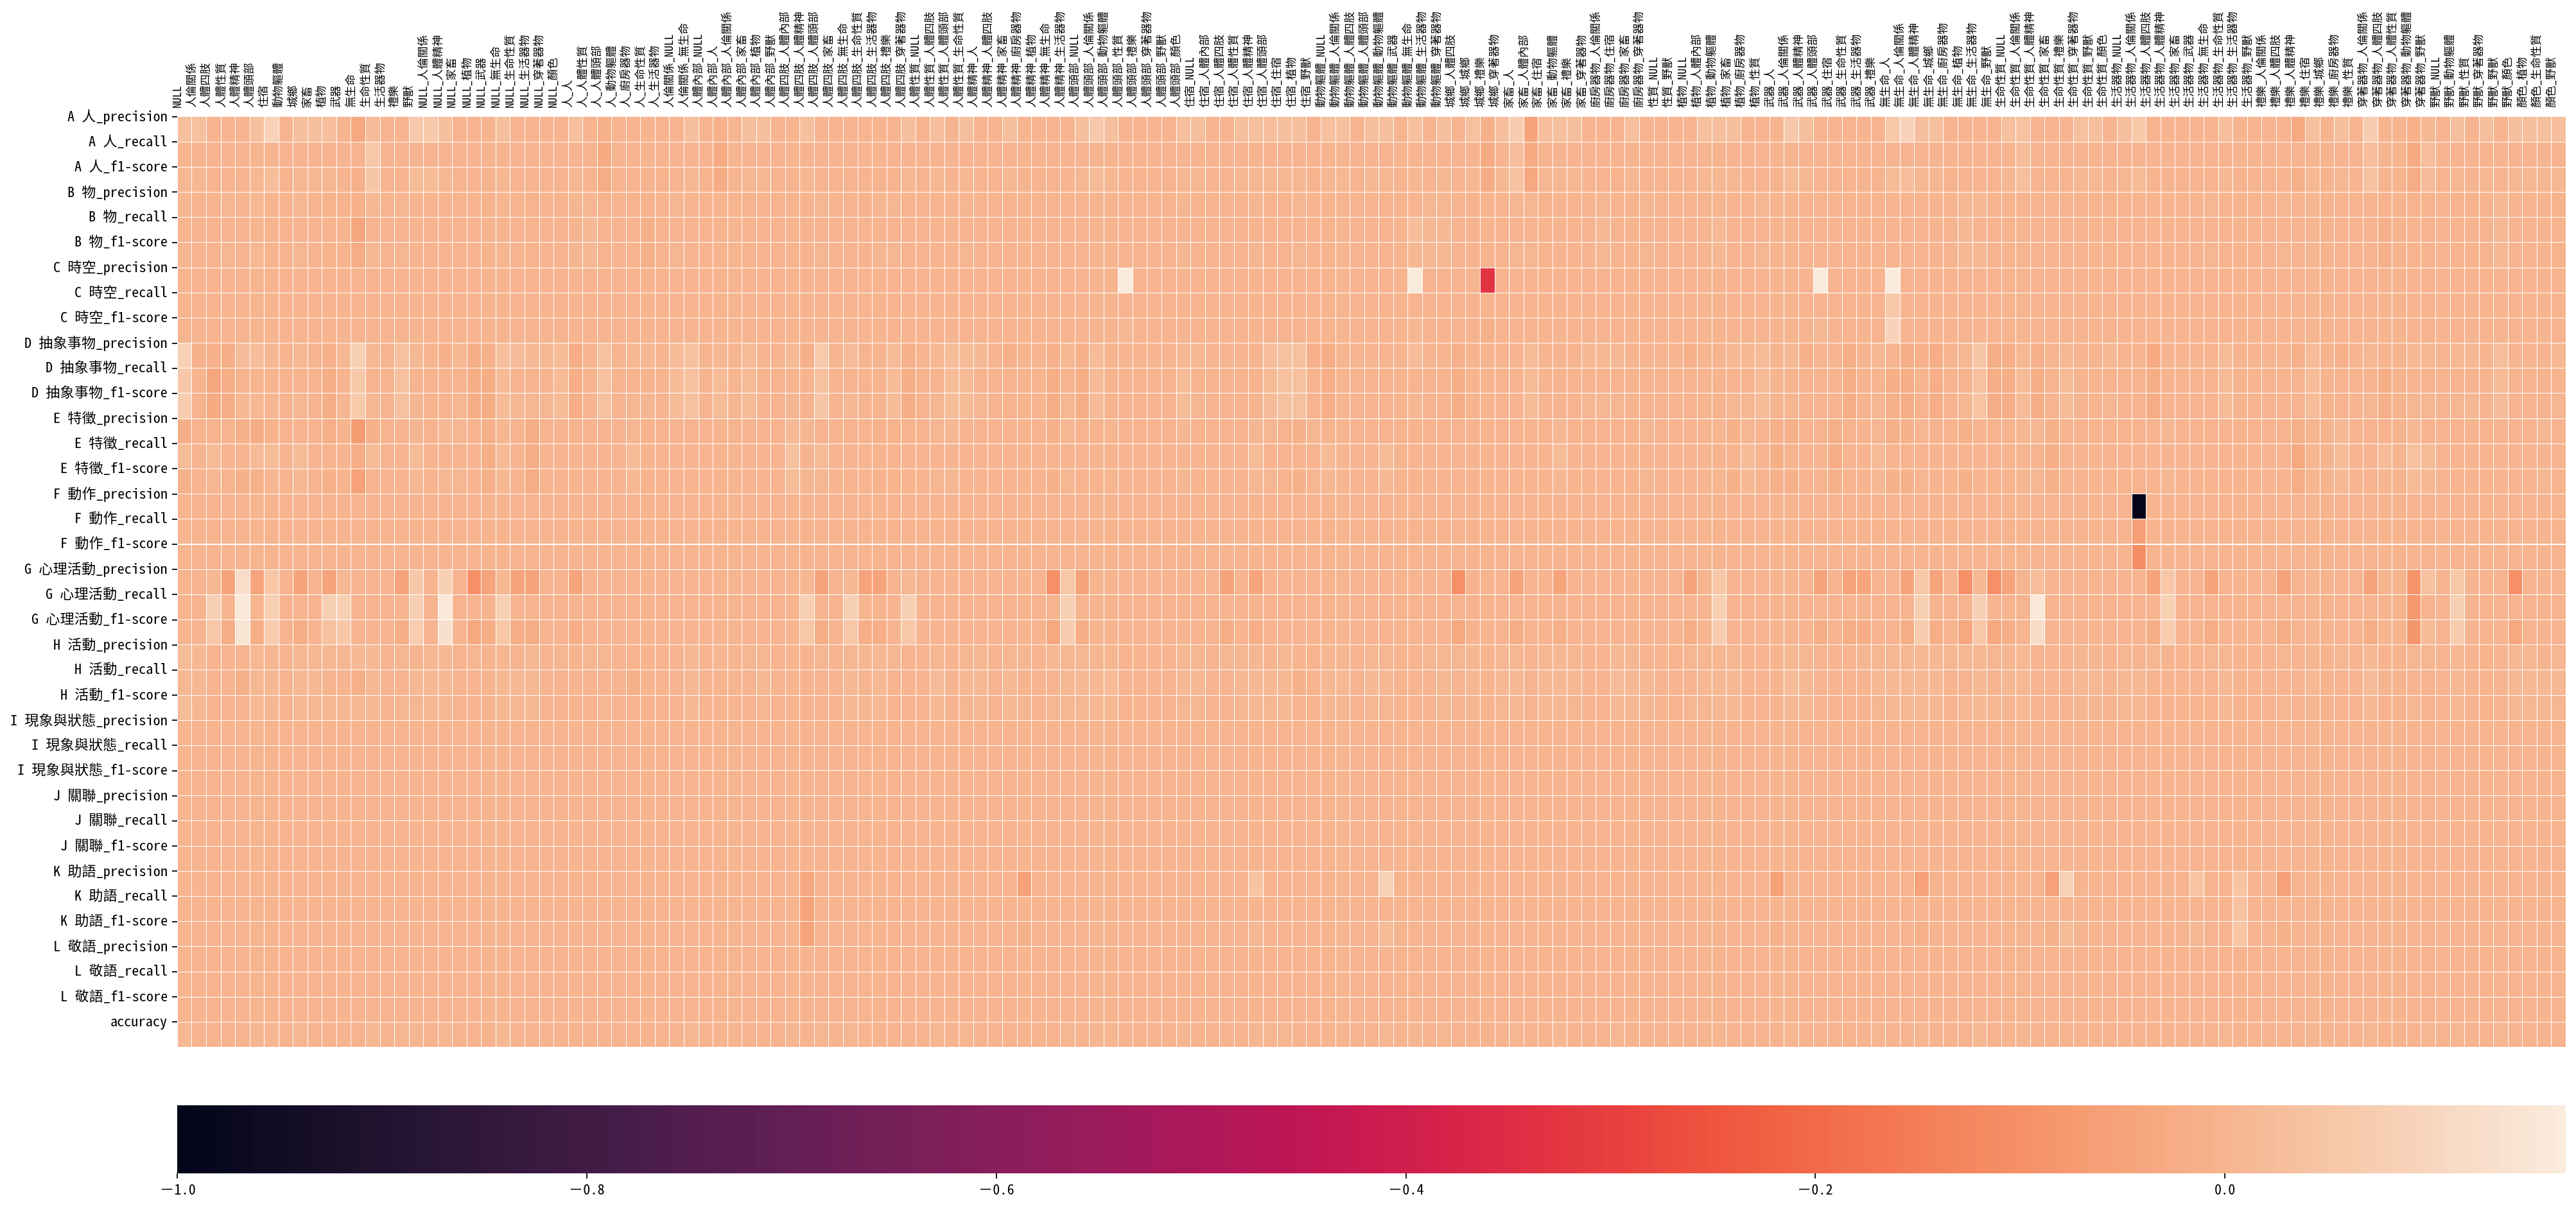

In [18]:
plt.figure(figsize=(30, 15), dpi=160)

dfT = df.T
ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                 cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
ax.set_yticks(range(dfT.shape[0])) # <--- set the ticks first
ax.set_yticklabels(dfT.index, fontsize=10)
ax.set_xticks(range(dfT.shape[1])) # <--- set the ticks first
ax.set_xticklabels(dfT.columns)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90, fontsize=8)
plt.show()

### Refit model with Top-165 important features

In [69]:
df_importance_selected2 = df_importance[df_importance >= 0].dropna(axis=0, how='any')
df_importance_selected2

,accuracy,f1,precision,recall
NULL,0.008178,0.008935,0.015146,0.008178
人,0.000000,0.001190,0.000365,0.000000
人倫關係,0.004673,0.003707,0.000973,0.004673
人體四肢,0.004673,0.003202,0.003739,0.004673
人體性質,0.001168,0.001967,0.002766,0.001168
...,...,...,...,...
顏色_性質,0.000000,0.000000,0.000000,0.000000
顏色_植物,0.001168,0.000698,0.000635,0.001168
顏色_生命性質,0.001168,0.000854,0.000951,0.001168
顏色_穿著器物,0.000000,0.000000,0.000000,0.000000


In [70]:
from random import sample, seed

seed(10)

acc_546feat, acc_314feat, acc_165feat, acc_rnd165feat = [], [], [], []
f1_546feat, f1_314feat, f1_165feat, f1_rnd165feat = [], [], [], []
sampled_feat = sample(DTM.features, 160)
for i in range(100):
    df_feat, df_tgt = DTM.pd, DTM.df_tgt
    X_train, X_test, y_train, y_test = train_test_split(
        df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = i
    )
    X_train_sm, X_test_sm = X_train[df_importance_selected.index], X_test[df_importance_selected.index]
    X_train_sm2, X_test_sm2 = X_train[df_importance_selected2.index], X_test[df_importance_selected2.index]
    X_train_rnd, X_test_rnd = X_train[sampled_feat], X_test[sampled_feat]

    for xtrain, xtest, acc, f1 in zip([X_train, X_train_sm, X_train_sm2, X_train_rnd], 
                                  [X_test, X_test_sm, X_test_sm2, X_test_rnd], 
                                  [acc_546feat, acc_165feat, acc_314feat, acc_rnd165feat],
                                  [f1_546feat, f1_165feat, f1_314feat, f1_rnd165feat]):
        model = MultinomialNB(alpha=0.001)
        model.fit(xtrain, y_train)
        predictions = model.predict(xtest)
        acc.append(accuracy_score(y_test, predictions))
        f1.append(f1_score(y_test, predictions, average="weighted"))

In [71]:
from statistics import stdev, median, mean

df = pd.DataFrame([
    ["546 feats",          mean(acc_546feat),    stdev(acc_546feat),    mean(f1_546feat),    stdev(f1_546feat)],
    ["314 feats",          mean(acc_314feat),    stdev(acc_314feat),    mean(f1_314feat),    stdev(f1_314feat)],
    ["165 feats",          mean(acc_165feat),    stdev(acc_165feat),    mean(f1_165feat),    stdev(f1_165feat)],
    ["165 feats (random)", mean(acc_rnd165feat), stdev(acc_rnd165feat), mean(f1_rnd165feat), stdev(f1_rnd165feat)],
], columns=['model', 'Acc.mean', 'Acc.std', 'F1.mean', 'F1.std' ])
df

,model,Acc.mean,Acc.std,F1.mean,F1.std
0,546 feats,0.440888,0.018227,0.392584,0.017578
1,314 feats,0.406612,0.015411,0.339959,0.015068
2,165 feats,0.404439,0.015093,0.331498,0.014226
3,165 feats (random),0.324346,0.014266,0.246488,0.015678


## Some Tests

In [ ]:
# Naive Bayes Posterior: P(X_i|y)
#mat = np.exp(model.feature_log_prob_).T
mat = model.feature_log_prob_.T
mat = pd.DataFrame(mat, index=DTM.features, columns=model.classes_).T
mat

,NULL,人,人倫關係,人體內部,人體四肢,人體性質,人體精神,人體頭部,住宿,動物軀體,城鄉,家畜,廚房器物,性質,植物,武器,無生命,生命性質,生活器物,禮樂,穿著器物,野獸,顏色
A 人,-2.376655,-2.235395,-2.059621,-5.195376,-2.554878,-4.968077,-4.147455,-2.779667,-3.018277,-5.886691,-3.632131,-3.702643,-5.314882,-3.422171,-3.031437,-3.785313,-2.507358,-2.287746,-3.508407,-4.270666,-3.331255,-3.723537,-5.029154
B 物,-2.825967,-3.618996,-3.290451,-4.139421,-2.668580,-5.786956,-4.844553,-3.048141,-3.152344,-4.105586,-3.325587,-3.624696,-4.062039,-3.411256,-2.000196,-3.853920,-1.664090,-3.290896,-3.587636,-4.881086,-2.789183,-2.848255,-3.762662
C 時空,-2.060038,-2.885582,-3.475231,-6.888243,-2.957646,-6.049781,-5.044695,-3.060124,-3.071231,-5.499798,-2.689217,-5.343964,-5.154269,-3.564002,-2.322321,-3.507384,-1.443196,-2.680739,-4.477548,-4.527466,-3.287676,-4.460097,-4.129516
D 抽象事物,-2.137212,-2.920629,-3.527319,-4.349630,-2.495929,-5.350698,-3.081364,-2.945896,-3.262168,-5.107369,-3.031534,-3.844411,-4.752533,-3.604164,-2.500698,-3.349826,-1.966092,-3.015748,-3.578053,-3.602216,-3.070914,-3.861297,-3.833925
E 特徵,-2.202109,-3.062194,-3.674641,-5.105987,-2.464344,-5.862133,-3.247812,-2.861097,-2.984583,-5.185950,-3.429426,-3.805003,-4.471981,-3.573579,-2.587045,-3.557557,-1.739036,-2.757485,-3.804742,-4.205354,-3.206892,-3.516845,-3.622910
F 動作,-2.547787,-2.900187,-4.992522,-7.947467,-1.257359,-4.118118,-4.816979,-2.337786,-3.006686,-4.332575,-4.519806,-3.916261,-4.431405,-3.983130,-3.258398,-2.988487,-2.388835,-2.699204,-3.786233,-4.144894,-3.748497,-3.987854,-6.250042
G 心理活動,-2.012486,-3.160328,-4.160232,-4.848871,-2.631421,-5.330984,-1.711773,-2.633997,-3.538217,-5.043825,-3.984684,-3.727024,-5.912851,-4.347825,-3.552218,-3.551174,-1.604313,-3.073344,-3.853792,-4.398411,-4.487959,-3.841791,-5.008219
H 活動,-2.228500,-2.777878,-3.917055,-5.557865,-1.872390,-4.516529,-4.037551,-2.961262,-3.299044,-4.946404,-3.586314,-3.783447,-3.820124,-3.487162,-2.859562,-3.137638,-2.063424,-2.986547,-3.140643,-3.574716,-3.251185,-3.662254,-4.466976
I 現象與狀態,-2.191941,-3.038063,-3.686735,-5.008289,-2.018702,-6.156962,-3.822508,-2.825491,-3.290864,-5.420264,-3.407158,-3.987643,-4.069795,-3.590796,-2.826944,-3.366620,-1.684610,-2.968462,-3.715589,-3.586233,-3.223765,-3.863165,-4.500293
J 關聯,-2.225884,-2.736101,-3.634023,-5.430471,-1.916247,-5.483044,-3.375546,-2.662666,-3.356664,-4.113481,-3.193194,-3.854332,-4.428500,-3.921830,-2.793016,-3.079801,-1.921470,-2.776853,-4.005211,-4.651118,-3.518181,-4.278557,-4.726978


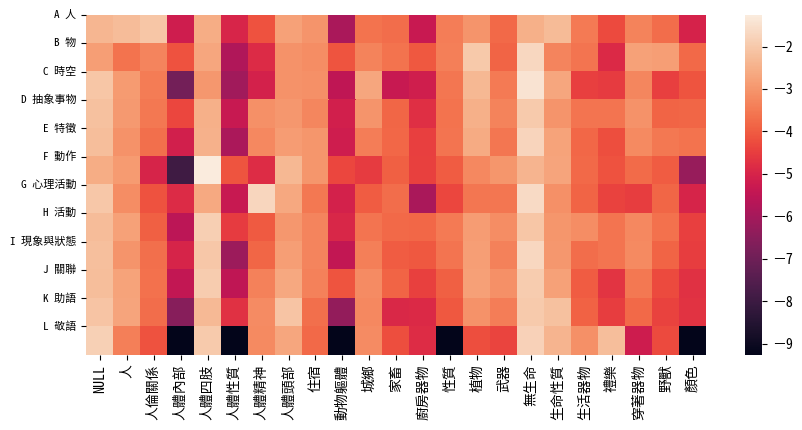

In [ ]:
plt.figure(figsize=(10, 4.5), dpi=100)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=8)
plt.show()
# ax = sns.heatmap(tf_idf_mat.toarray(), linewidth=0.5)
# plt.imshow(mat, cmap='hot', interpolation='nearest')

In [ ]:
# Tfidf matrix
DTM = DocumentTermMatrix(Tagger, C, level=1)
mat = pd.DataFrame(DTM.np.T, index=DTM.features, columns=DTM.df_tgt.lev1).T
# mat

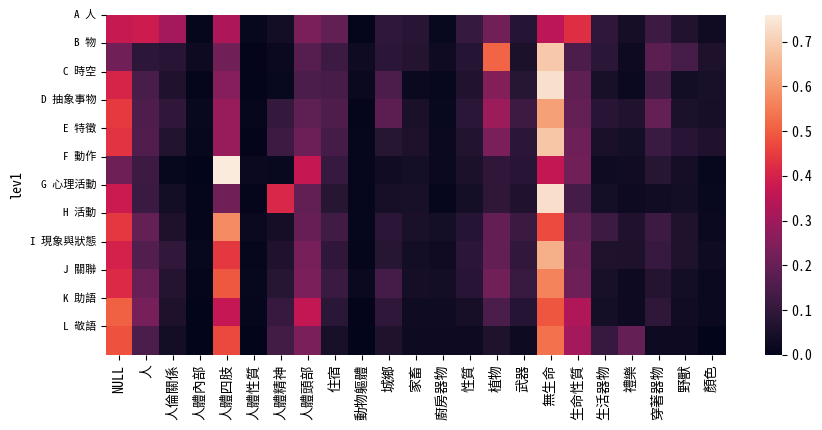

In [ ]:
plt.figure(figsize=(10, 4.5), dpi=100)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=8)
plt.show()